# Blind Search Algorithms

Blind Search algorithms can be split into **traversal** and **shortest path** algorithms.

---

## Graph Traversal Algorithms

Graph traversal refers to a process that traverses vertices of a graph following a certain order (starting from user-input sources). This category of graph search algorithms only seeks to find a path between two nodes, without optimizing for the length of the final route. In applications where the weight of edges in a graph are all equal (e.g. 1), BFS and DFS algorithms outperform shortest path algorithms like Dijkstra's. 



### Setup

Let's first find the largest connected component centered around our location, with a specified distance on each side. The reference point is the centre of the University of Toronto's downtown campus.

To plot the network, we will also need to highlight the starting and ending nodes. For the sake of simplicity, we will use the node id directly. To review how to get the closest node to a given location, refer back to [the previous section](RoadGraph.ipynb).

:::{note}
This book uses the `smart_mobility_utilities` package for some operations, in order to simplify the process of visualizing graphs. You can find out more about downloading and installing the package [here](../ToolsAndPythonLibraries/index.md#smart_mobility_utilities-python-package).
:::



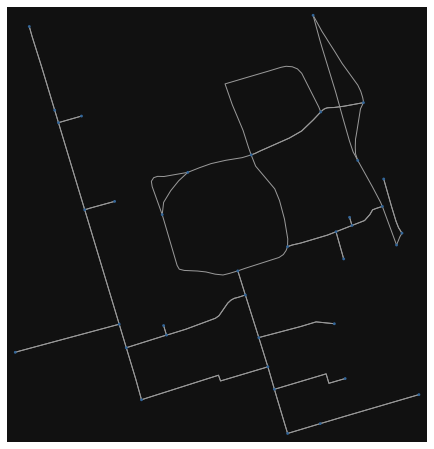

In [18]:
import osmnx
from smart_mobility_utilities.common import cost, Node
from smart_mobility_utilities.viz import draw_route, draw_map
import math
import heapq
from collections import deque

reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)

highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

Let's visualize the above graph on a `ipyleaflet` map, using a helper function from the `smart_mobility_utilities` package.

In [2]:
draw_map(G,highlight=highlighted, force_leaflet=True)

Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

:::{warning}
For the purposes of this map, we use the `force_leaflet` option so that the map will be rendered by `ipyleaflet`. Normally, when there are more than 1,000 nodes in a graph, `ipyleaflet` performance is very slow. The visualization tools in `smart_mobility_utilities` will automatically switch to `folium` when there are more than 1,000 nodes, unless the `force_leaflet` flag is used. See the docs for `smart_mobility_utilities` for more information.
:::

Currently, each node in the above graph is represented as a python `dict` with many attributes that are of no interest to us. This makes accessing certain properties of nodes overly complicated and verbose. To minimize this, we can use the `Node` class from `smart_mobility_utilities.common` to redefine the nodes, and only retain key information like parent, edge length from parent, and the node itself.

In [3]:
# First convert the source and destination nodes to Node
origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

---
### Breadth-first Search (BFS)

 BFS is an algorithm where the traversal starts at a specified node (the source or starting node) and continues along the graph layerwise, thus exploring all exploring all of the the current node's neighbouring nodes (those which are directly connected to the current node). If a result is not found, the algorithm proceeds to search the next-level neighbour nodes.
<br><br>
<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>BREADTH-FIRST-SEARCH</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">frontier</font></i> &larr; <span>a <b>FIFO</b> initialized with <i>source</i> node</span><br>
        <i><font color="grey">explored</font></i> &larr; <i>empty</i><br>
        <i><font color="blue">found</font></i> &larr; <i>False</i><br><br>
        while <i><font color="green">frontier</font></i> is not <i>empty</i> and <i><font color="blue">found</font></i> is <i>False</i>  do<br>
        <div style='padding-left:20px;'>
            <i>node</i> &larr; <i><font color="green">frontier</font></i>.pop()<br>
            add <i>node</i> to <i><font color="grey">explored</font></i><br>
            for <i>child</i> in <i>node</i>.expand() do
            <div style='padding-left:20px;'>
                if <i>child</i> is not in <i><font color="grey">explored</font></i> and <i>child</i> is not in <i><font color="green">frontier</font></i> then
                <div style='padding-left:20px;'>
                    if <i>child</i> is <i>destination</i> then
                    <div style='padding-left:20px;'>
                        <i>route</i> &larr; <i>child</i>.route()<br>
                        <i><font color="blue">found</font></i> &larr; <i>True</i>
                    </div>
                    add <i>child</i> to <i><font color="green">frontier</font></i>
                </div>
            </div>
        return <i>route</i>
        </div>
    </div>
</div>


<br><br>
Using BFS, search for the shortest path between The Equestrian Statue and the Bahen Centre. This example uses the same data as in [From Road Network to Graph](RoadGraph.ipynb).

In [4]:
def BFS(G, origin, destination):
    route = []
    frontier = deque([origin])
    explored = set()
    found = False

    while frontier and not found:
        node = frontier.popleft()
        explored.add(node)
        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    found = True
                frontier.append(child)
    return route

In [5]:
route = BFS(G,origin, destination)
print(f"Route: {route}")
print(f"Cost: {cost(G,route)}")
draw_route(G, route)

Route: [55808290, 304891685, 55808284, 1721866234, 389678268, 4953810915, 389678267, 24960090, 24960068, 1258698109, 389678145, 24960070, 24960073, 24960076, 24960080, 6028561924, 5098988924, 389678131, 2557539841, 389678133, 389677909]
Cost: 954.727


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

--- 

### Depth-first Search (DFS)

The DFS algorithm is a recursive algorithm that uses the idea of **backtracking**. It involves exhaustive searches of all the nodes by going as deep as possible into the graph. When it reaches the last layer with no result, it "backtracks" up a layer and continues the search.


<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>DEPTH-FIRST-SEARCH</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">frontier</font></i> &larr; <span>a <b>LIFO</b> initialized with <i>source</i> node</span><br>
        <i><font color="grey">explored</font></i> &larr; <i>empty</i><br>
        <i><font color="blue">found</font></i> &larr; <i>False</i><br><br>
        while <i><font color="green">frontier</font></i> is not <i>empty</i> and <i><font color="blue">found</font></i> is <i>False</i>  do<br>
        <div style='padding-left:20px;'>
            <i>node</i> &larr; <i><font color="green">frontier</font></i>.pop()<br>
            add <i>node</i> to <i><font color="grey">explored</font></i><br>
            for <i>child</i> in <i>node</i>.expand() do
            <div style='padding-left:20px;'>
                if <i>child</i> is not in <i><font color="grey">explored</font></i> and <i>child</i> is not in <i><font color="green">frontier</font></i> then
                <div style='padding-left:20px;'>
                    if <i>child</i> is <i>destination</i> then
                    <div style='padding-left:20px;'>
                        <i>route</i> &larr; <i>child</i>.route()<br>
                        <i><font color="blue">found</font></i> &larr; <i>True</i>
                    </div>
                    add <i>child</i> to <i><font color="green">frontier</font></i>
                </div>
            </div>
        return <i>route</i>
        </div>
    </div>
</div>

<br><br>
As you may have the noticed, the only difference between DFS and BFS is in the way that `frontier` works. Rather than working down layer by layer (FIFO), DFS drills down to the bottom-most layer and moves its way back to the starting node (LIFO).

Let's implement this algorithm with our previous example.

In [6]:
def DFS(G, origin, destination):
    route = []
    frontier = deque([origin])
    explored = set()
    found = False

    while frontier and not found:
        node = frontier.pop()
        explored.add(node)
        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route  = child.path()
                    found = True
                    continue
                frontier.append(child)
    return route

In [7]:
route = DFS(G,origin, destination)
print(f"Route: {route}")
print(f"Cost: {cost(G,route)}")
draw_route(G,route)

Route: [55808290, 55808177, 55808169, 55808239, 389678268, 4953810915, 4953810914, 55808233, 299625330, 24959523, 50885177, 389677947, 1840221695, 1840221686, 1840221676, 783622470, 389678138, 3707407638, 6028561924, 6028561921, 389678124, 6028562355, 2557542523, 389677907, 389678038, 389678039, 389678040, 2143436381, 389678041, 389678184, 389678183, 389678216, 7311057931, 749951161, 242413453, 749952029, 389677909]
Cost: 1521.548


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

It is very evident that the paths generated by our DFS and BFS implementations are not the most direct route. This is because both DFS and BFS are algorithms that can find routes between two nodes, but make no guarantees that they will return the **shortest path**. Additionally, DFS generally returns "deeper" results as it traverses the entire depth of the graph and works backwards to find a solution.

---

## Shortest Path Algorithms
### Dijkstra Search

Dijkstra's algorithm allows us to find the shortest path between any two vertices of a graph. The algorithm creates a tree of shortest paths from the starting vertex, the source, to all other points in the graph.  Dijkstra's algorithm , published in 1959 and named after Dutch computer scientist Edsger Dijkstra, is the base of several other graph search algorithms commonly used to solve routing problems in popular navigation apps.

![](../../images/Dijkstra.png)

<br>
The following pseudocode and `python` implementation for Dijkstra's algorithm has been modified to work with our OSM data. This is because graphs generated from maps will naturally have self-loops and parallel edges. 

Parallel edges may result in a route that is not the shortest available, as the route length depends heavily on which parallel edge was chosen when a particular path was generated. In the example below, the shortest path **may** be returned as 7, if the first edge connecting `0` and `1` is chosen when calculating that path.

![](../../images/parallel.png)



Self-loops also cause trouble for the original Dijkstra algorithm. If a graph contains a self-loop, it may be the case that the shortest path to a node comes from itself. At that point, we would be unable to generate a route.

![](../../images/self-loop.png)


These two issues are generally easy but non-trivial to avoid. For parallel edges, we select the edge with the lowest weight (shortest length), and discard any other parallel edge. 


With self-loops, we can ignore the loop entirely as negative-weight loops do not exist in routing problems (a road cannot have negative length), and positive-weight loops cannot be part of a shortest path. <br><br>

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>DIJKSTRA-SEARCH</b>(<i>graph</i>,<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">shortest_dist</font></i> &larr; <i>empty</i><br>
        <i><font color="grey">unrelaxed_nodes</font></i> &larr; <i>empty</i><br>
        <i><font color="blue">seen</font></i> &larr; <i>empty</i><br><br>
        <font color="#03A9F4">// initialize the lists</font><br>
        for <i>node</i> in <i>graph</i>
        <div style='padding-left:20px;'>
            <i><font color="green">shortest_dist</font></i>[<i>node</i>] = <i>Infinity</i><br>
            add <i>node</i> to <i><font color="grey">unrelaxed_nodes</font></i><br>
        </div><br>
        <i><font color="green">shortest_dist</font></i>[<i>source</i>] &larr; 0<br>
        <i><font color="orange">found</font></i> &larr; <i>False</i><br><br>
        while <i><font color="grey">unrelaxed_nodes</font></i> is not <i>empty</i> and <i><font color="orange">found</font></i> is <i>False</i> do
        <div style='padding-left:20px;'>
            <i>node</i> &larr; <i><font color="grey">unrelaxed_nodes</font></i>.pop()<br>
            add <i>node</i> to <i><font color="blue">seen</font></i><br>
            if <i>node</i> is <i>destination</i> then
            <div style='padding-left:20px;'>
                <i>route</i> &larr; <i>node</i>.route()<br>
                <i><font color="orange">found</font></i> &larr; <i>True</i>
            </div>
            for <i>child</i> in <i>node</i>.expand() do
            <div style='padding-left:20px;'>
                if <i>child</i> in <i><font color="blue">seen</font></i> then skip<br>
                <i>distance</i> &larr; <i><font color="green">shortest_dist</font></i>[<i>node</i>] + length of edge to <i>child</i><br>
                if <i>distance</i> < <i><font color="green">shortest_dist</font></i>[<i>child</i>] then
                <div style='padding-left:20px;'>
                    <i><font color="green">shortest_dist</font></i>[<i>child</i>] &larr; <i>distance</i><br>
                    <i>child</i>.parent &larr; <i>node</i>
                </div>
            </div>
        </div>
    </div>
    return <i>route</i>
</div>
<br><br>

In [11]:
def Dijkstra(G, origin, destination):
    # Using a set here avoids the problem with self loops
    seen = set()
    shortest_dist = {osmid: math.inf for osmid in G.nodes()}
    unrelaxed_nodes = [Node(graph=G, osmid=osmid) for osmid in G.nodes()]
    shortest_dist[origin.osmid] = 0
    found = False
    while len(unrelaxed_nodes) > 0 and not found:
        node = min(unrelaxed_nodes, key=lambda node: shortest_dist[node.osmid])
        # relaxing the node, so this node's value in shortest_dist is the shortest distance between the origin and destination
        unrelaxed_nodes.remove(node)
        seen.add(node.osmid)
        # if the destination node has been relaxed then that is the route we want
        if node == destination:
            route = node.path()
            found = True
            continue
        # otherwise, let's relax edges of its neighbours
        for child in node.expand():
            # skip self-loops
            if child.osmid in seen:
                continue
            child_obj = next(
                (node for node in unrelaxed_nodes if node.osmid == child.osmid), None
            )
            child_obj.distance = child.distance
            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node
    return route

In [12]:
route = Dijkstra(G, origin, destination)
print(f"Route: {route}")
print(f"Cost: {cost(G,route)}")
draw_route(G, route)

Route: [55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 24959523, 50885177, 389677947, 2143489692, 2480712846, 389678140, 389678139, 389678138, 3707407638, 6028561924, 5098988924, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909]
Cost: 801.464


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

### Uniform-Cost Search (UCS)

Uniform-Cost Search (UCS) algorithm is a blind search algorithm that uses the lowest cumulative cost to find a path from the origin to the destination. This variant of Dijkstra's algorithm is useful for large graphs as it is less time consuming and has fewer space requirements, where the priority queue is filled gradually as opposed to Dijkstra's, which adds all nodes to the queue on start with an infinite cost. 

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>UNIFORM-COST-SEARCH</b>(<i>graph</i>,<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">priority_queue</font></i> &larr; <i>source</i><br>
        <i><font color="orange">found</font></i> &larr; <i>False</i><br>
        <i><font color="purple">seen</font></i> &larr; <i>source</i><br><br>
        while <i><font color="green">priority_queue</font></i> is not <i>empty</i> and <i><font color="orange">found</font></i> is <i>False</i> do
        <div style='padding-left:20px;'>
            <i>node</i> &larr; <i><font color="green">priority_queue</font></i>.pop()<br>
            <i><font color="purple">seen</font></i> &larr; <i>node</i><br>
            <i><font color="blue">node_cost</font></i> &larr; cumulative distance from origin<br>
            if <i>node</i> is <i>destination</i> then
            <div style='padding-left:20px;'>
                <i>route</i> &larr; <i>node</i>.route()<br>
                <i><font color="orange">found</font></i> &larr; <i>True</i>
            </div>
            for <i>child</i> in <i>node</i>.expand() do
            <div style='padding-left:20px;'>
                if <i>child</i> in <i><font color="green">priority_queue</font></i> then<br>
                <div style='padding-left:20px;'>
                    if <i>child</i>.priority < <i><font color="green">priority_queue</font></i>[<i>child</i>].priority then<br>
                    <div style='padding-left:20px;'>
                        <i><font color="green">priority_queue</font></i>[<i>child</i>].priority = <i>child</i>.priority<br>
                    </div>
                </div>
                else<br>
                <div style='padding-left:20px;'>
                    <i><font color="green">priority_queue</font></i> &larr; <i>child</i><br>
                    <i><font color="green">priority_queue</font></i>[<i>child</i>].priority &larr; <i><font color="blue">node_cost</font></i><br>
                </div>
            </div>
        </div>
        return <i>route</i>
    </div>
    
</div>
<br><br>

Essentially, the algorithm organizes nodes to be explored by their cost (with lowest cost as highest priority). As nodes are popped from the queue, the node's children are added to the queue. If a child already exists in the priority queue, the priorities of both copies of the child are compared, and the lowest cost (highest priority) is accepted. This ensures that the path to each child is the shortest one available. We also maintain a visited list to avoid revisiting nodes that have already been popped from the queue.

In [16]:
# This implementation uses a heap with tuples (a,b),
# a is the cost of a node, and b is the node id.
def UCS(G, origin, destination):
    entry_count = 1
    priority_queue = [(0, 0, origin)]
    found = False
    visited = []
    while priority_queue and not found:
        node = heapq.heappop(priority_queue)
        node_cost = node[0]
        node = node[2]
        if node in visited:
            continue
        visited.append(node)
        # We found the destination
        if node == destination:
            route = node.path()
            found = True
            continue
        for child in node.expand():
            total_cost = child.distance + node_cost
            matches = [item for item in priority_queue if item[2] == child]
            if matches:
                # Update the entry if the new priority is better
                if total_cost < matches[0][0]:
                    priority_queue[priority_queue.index(matches[0])] = (
                        total_cost,
                        entry_count,
                        child,
                    )
                    entry_count += 1
                    heapq.heapify(priority_queue)
            else:
                heapq.heappush(priority_queue, (total_cost, entry_count, child))
                entry_count += 1
    return route

In [17]:
route = UCS(G, origin, destination)
print(f"Route: {route}")
print(f"Cost: {cost(G,route)}")
draw_route(G, route)

Route: [55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 24959523, 50885177, 389677947, 2143489692, 2480712846, 389678140, 389678139, 389678138, 3707407638, 6028561924, 5098988924, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909]
Cost: 801.464


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

As you can see, the results are identical to that of Dijkstra's (the optimal solution), but this algorithm handles larger graphs much better, as it does not require all the nodes to be added to the queue at the very beginning.